In [103]:
%reload_ext jupyter_ai
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
import os

from IPython.display import Image
from tqdm import tqdm

# Day 9 - Monte Carlo Methods

## Incremental Implementation

* To create an incremental implementation for ordinary importance sampling is straightforward
* For weighted importance sampling, instead of updating $N(s,a)\leftarrow N(s,a)+1$, we update the cumulative sum $C$ of importance sampling weights $W$

$$
\begin{align}
C_{n+1}&\doteq C_n+W_{n+1}
\end{align}
$$
* The new update rule for a value function $V$ is slightly different as well, no longer being able to simplify from $\frac{N-1}{N}$

$$
\begin{align}
V_{n+1}&\doteq V_n+\frac{W_n}{C_n}[G_n-V_n]
\end{align}
$$

* Equivalence is shown like this:
$$
\begin{align}
V_n+\frac{W_n}{C_n}\left[G_n-V_n\right]&=\frac{C_nV_n+W_nG_n-W_nV_n}{C_n} \\
&=\frac{V_n(C_n-W_n)+W_nG_n}{C_n} \\
&=\frac{\sum_{k=1}^{n-1}W_kG_k+W_nG_n}{\sum_{k=1}^nW_n} \\
&=\frac{\sum_{k=1}^{n}W_kG_k}{\sum_{k=1}^nW_n} \\
&=V_{n+1}
\end{align}
$$

### $Exercise\ \mathcal{5.9}$

#### Modify the algorithm for first-visit MC policy evaluation (Section 5.1) to use the incremental implementation for sample averages described in Section 2.4.

This is already described in detail in my solution to $Exercise\ \mathcal{5.4}$.

### $Exercise\ \mathcal{5.10}$

#### Derive the weighted-average update rule (5.8) from (5.7). Follow the pattern of the derivation of the unweighted rule (2.3).

Instead of deriving the update rule, I already proved equivalence when taking notes while reading the section, so I'll reproduce that here:

$$
\begin{align}
V_n+\frac{W_n}{C_n}\left[G_n-V_n\right]&=\frac{C_nV_n+W_nG_n-W_nV_n}{C_n} \\
&=\frac{V_n(C_n-W_n)+W_nG_n}{C_n} \\
&=\frac{\sum_{k=1}^{n-1}W_kG_k+W_nG_n}{\sum_{k=1}^nW_n} \\
&=\frac{\sum_{k=1}^{n}W_kG_k}{\sum_{k=1}^nW_n} \\
&=V_{n+1}
\end{align}
$$

## Off-policy Monte Carlo Control

* To extend off-policy methods to control, we simply update the target policy to be greedy with respect to the value estimates
* In order to continue learning about all possible actions, the behavior policy just has to be $\varepsilon$-soft
* As importance sampling weights for all suboptimal actions are zero, this method only learns from the tails of episodes, after the final non-greedy action (and the action-value of this non-greedy action)

### $Exercise\ \mathcal{5.11}$

#### In the boxed algorithm for off-policy MC control, you may have been expecting the W update to have involved the importance-sampling ratio $\frac{\pi(A_t|S_t)}{b(A_t|S_t)}$, but instead it involves $\frac{1}{b(A_t|S_t)}$. Why is this nevertheless correct? 

As the policy $\pi$ is greedy with respect to the value estimates $Q(s,a)$, the probability of choosing an action is either $0$ or $1$. The algorithm exits the loop as soon as a non-greedy action is encountered, so the relevant weights are always exactly $\frac{1}{b(A_t|S_t)}$.

### $Exercise\ \mathcal{5.12}$*:* $Racetrack\ (programming)$

#### Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by $+1$, $-1$, or $0$ in each step, for a total of nine $(3\times3)$ actions. Both velocity components are restricted to be nonnegative and less than $5$, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are  1 for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

~~No. Are you insane? I'm not writing all that code for a racetrack I don't care about, just so I can test a Monte Carlo algorithm. What the hell?~~

Sure:

<Axes: >

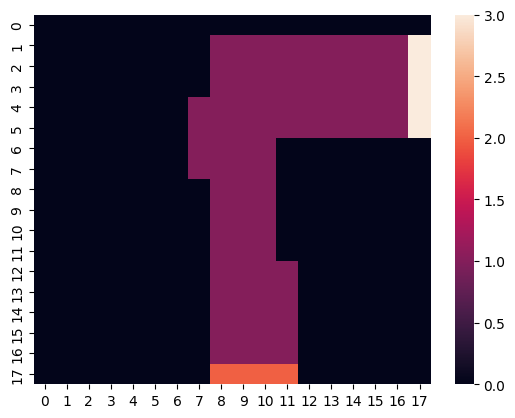

In [59]:
# 0 = Boundary
# 1 = Track
# 2 = Start
# 3 = Finish
track = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
])

fig, ax = plt.subplots()
sns.heatmap(track)

<Axes: >

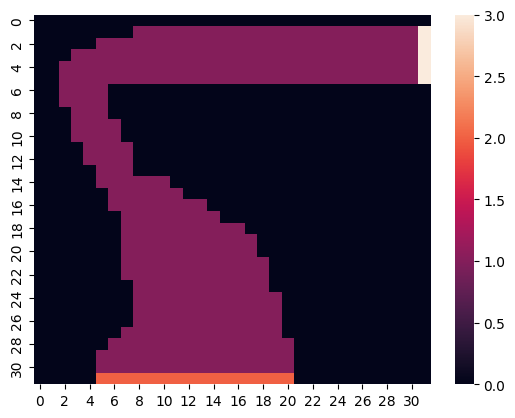

In [106]:
# 0 = Boundary
# 1 = Track
# 2 = Start
# 3 = Finish
track = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])

fig, ax = plt.subplots()
sns.heatmap(track)

In [ ]:
# 0 = Boundary
# 1 = Track
# 2 = Start
# 3 = Finish
track = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
    [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])

fig, ax = plt.subplots()
sns.heatmap(track)

In [194]:
def clamp(val, lower, upper):
    return max(lower, min(upper, val))


def direction(val):
    if val == 0:
        return 0
    return val / abs(val)


class RaceTrack:
    def __init__(self, track):
        self.track = track
        self.max_speed = 5
        self.state_space = (
            # x position
            self.track.shape[0],
            # y position
            self.track.shape[1],
            # x speed
            2 * self.max_speed + 1,
            # y speed
            2 * self.max_speed + 1,
        )
        self.action_space = (3, 3)
        self.reset()

    def reset(self):
        start_xs, start_ys = np.where(self.track == 2)
        i = np.random.choice(range(len(start_ys)))
        # (x, y, x_vel, y_vel)
        self.state = (start_xs[i], start_ys[i], 0, 0)
        return self.state

    def clamp_speed(self, speed):
        return clamp(speed, -self.max_speed, self.max_speed)

    def step(self, action, test=False):
        x, y, x_vel_old, y_vel_old = self.state
        x_vel = self.clamp_speed(x_vel_old + direction(action[0]))
        y_vel = self.clamp_speed(y_vel_old + direction(action[1]))

        # Reset speed in one direction if both are zero
        if x_vel == 0 and y_vel == 0:
            if np.random.random() > 0.5:
                x_vel = x_vel_old
            else:
                y_vel = y_vel_old

        # During training, inject some noise by ignoring actions
        # sometimes
        if not test and np.random.random() < 0.1:
            x_vel, y_vel = x_vel_old, y_vel_old

        to_go = [x_vel, y_vel]
        while to_go[0] != 0 or to_go[1] != 0:
            if to_go[0] != 0 and to_go[1] != 0:
                d = 0 if np.random.random() > 0.5 else 1
            elif to_go[0] != 0:
                d = 0
            else:
                d = 1
                
            sign = to_go[d] / abs(to_go[d])
            if d == 0:
                x += sign
            else:
                y += sign
            to_go[d] -= sign

            x, y = int(x), int(y)
            if x not in range(self.track.shape[0]) or y not in range(self.track.shape[1]):
                return self.reset(), -2, False
            loc = self.track[x,y]
            # Hit a boundary, loss!
            if loc == 0:
                return self.reset(), -2, False
            # Reached the finish line, win!
            elif loc == 3:
                self.state = (int(x), int(y), int(x_vel), int(y_vel))
                return self.state, 100, True

        self.state = (int(x), int(y), int(x_vel), int(y_vel))
        return self.state, -1, False

In [ ]:
racetrack = RaceTrack(track)
track_state = racetrack.track.copy()
state = racetrack.state
track_state[state[0], state[1]] = 10
sns.heatmap(track_state)

In [ ]:
state, reward, done = racetrack.step((0, 1))
print(state, reward, done)
track_state = racetrack.track.copy()
track_state[state[0], state[1]] = 10
sns.heatmap(track_state)

In [4]:
def index_to_action(i):
    actions = np.array([
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1), ( 0, 0), ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1),
    ])
    
    return actions[i]


class MonteCarloControl:
    def __init__(self, epsilon, racetrack):
        track_height, track_width, x_vels, y_vels = racetrack.state_space
        x_actions, y_actions = racetrack.action_space
        self.num_actions = x_actions * y_actions
        self.Q = np.zeros((
            track_height,
            track_width,
            x_vels,
            y_vels,
            self.num_actions,
        ))
        self.N = np.zeros_like(self.Q)
        self.epsilon = epsilon
        self.track = racetrack

    def select_action(self, state, greedy=False):
        x, y, x_vel, y_vel = state
        index = np.argmax(self.Q[x, y, x_vel, y_vel, :])
        if not greedy and np.random.random() < self.epsilon:
            index = np.random.randint(0, self.num_actions)
        return index

    def train(self, num_episodes=100_000):
        original_epsilon = self.epsilon
        self.track.reset()
        for e in tqdm(range(num_episodes)):
            threshold = num_episodes // 10
            self.epsilon = max(
                original_epsilon,
                1 - (e / threshold) * (1 - original_epsilon)
            )
            x, y, x_vel, y_vel = self.track.state
            states = [(x, y, x_vel, y_vel)]
            actions = []
            rewards = []
            ret = 0
            while True:
                index = self.select_action((x, y, x_vel, y_vel))
                actions.append(index)
                action = index_to_action(index)
                (x, y, x_vel, y_vel), reward, done = self.track.step(action)
                rewards.append(reward)
                states.append((x, y, x_vel, y_vel))
                if done:
                    break
            for t in range(len(states) - 2, -1, -1):
                x, y, x_vel, y_vel = states[t]
                ret += rewards[t]
                self.N[x, y, x_vel, y_vel, actions[t]] += 1
                self.Q[x, y, x_vel, y_vel, actions[t]] += (1 / self.N[x, y, x_vel, y_vel, actions[t]]) * \
                    (ret - self.Q[x, y, x_vel, y_vel, actions[t]])

    def play_episode(self):
        episode = []
        x, y, x_vel, y_vel = self.track.reset()
        episode.append((x, y, x_vel, y_vel))
        done = False
        while not done:
            index = self.select_action((x, y, x_vel, y_vel), greedy=True)
            action = index_to_action(index)
            (x, y, x_vel, y_vel), reward, done = self.track.step(action, test=True)
            episode.append((x, y, x_vel, y_vel))

        return episode

In [229]:
racetrack = RaceTrack(track)
agent = MonteCarloControl(0.01, racetrack)

In [230]:
agent.train()

  0%|                                                             | 1/100000 [00:40<1133:38:27, 40.81s/it]


KeyboardInterrupt: 

In [ ]:
episode = agent.play_episode()
frames = []
for state in episode:
    track_state = racetrack.track.copy()
    track_state[state[0], state[1]] = 10
    fig, ax = plt.subplots()
    sns.heatmap(track_state, ax=ax)
    ax.axis('off')
    # Save the frame as an image
    plt.savefig('temp_frame.png', bbox_inches='tight', pad_inches=0)
    frames.append(imageio.v2.imread('temp_frame.png'))
    plt.close()

# Create a GIF from the collected frames
imageio.mimsave('episode_heatmap.gif', frames, fps=2)

# Clean up temporary files if needed
os.remove('temp_frame.png')
Image(url='episode_heatmap.gif')

## *Discounting-aware Importance Sampling

* This section is not likely to be all that relevant to me.

## *Per-decision Importance Sampling

* This section is not likely to be all that relevant to me.

In [227]:
def index_to_action(i):
    actions = np.array([
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1), ( 0, 0), ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1),
    ])
    
    return actions[i]


class QLearning:
    def __init__(self, epsilon, step_size, racetrack):
        track_height, track_width, x_vels, y_vels = racetrack.state_space
        x_actions, y_actions = racetrack.action_space
        self.num_actions = x_actions * y_actions
        self.Q = np.zeros((
            track_height,
            track_width,
            x_vels,
            y_vels,
            self.num_actions,
        ))
        self.epsilon = epsilon
        self.step_size = step_size
        self.track = racetrack
        self.ep_lengths = []

    def select_action(self, state, greedy=False):
        x, y, x_vel, y_vel = state
        index = np.argmax(self.Q[x, y, x_vel, y_vel, :])
        if not greedy and np.random.random() < self.epsilon:
            index = np.random.randint(0, self.num_actions)
        return index

    def train(self, num_episodes=100_000):
        original_epsilon = self.epsilon
        self.track.reset()
        for e in tqdm(range(num_episodes)):
            threshold = num_episodes // 33_333
            self.epsilon = max(
                original_epsilon,
                0.8 - (e / threshold) * (0.8 - original_epsilon)
            )
            x, y, x_vel, y_vel = self.track.state
            done = False
            ep_length = 0
            while not done:
                ep_length += 1
                index = self.select_action((x, y, x_vel, y_vel))
                action = index_to_action(index)
                (x_, y_, x_vel_, y_vel_), reward, done = self.track.step(action)
                self.Q[x, y, x_vel, y_vel, index] += self.step_size * \
                                            (reward + np.max(self.Q[x_, y_, x_vel_, y_vel_]) - \
                                             self.Q[x, y, x_vel, y_vel, index])
                x, y, x_vel, y_vel = x_, y_, x_vel_, y_vel_
            self.ep_lengths.append(ep_length)

    def play_episode(self):
        episode = []
        x, y, x_vel, y_vel = self.track.reset()
        episode.append((x, y, x_vel, y_vel))
        done = False
        while not done:
            index = self.select_action((x, y, x_vel, y_vel))
            action = index_to_action(index)
            (x, y, x_vel, y_vel), reward, done = self.track.step(action)
            episode.append((x, y, x_vel, y_vel))

        return episode

In [233]:
epsilon = 0.01
step_size = 0.01
racetrack = RaceTrack(track)
agent = QLearning(epsilon, step_size, racetrack)

In [254]:
agent.track.track = track

In [255]:
agent.train(1_000_000)

  0%|                                                                         | 0/1000000 [21:08<?, ?it/s]


KeyboardInterrupt: 

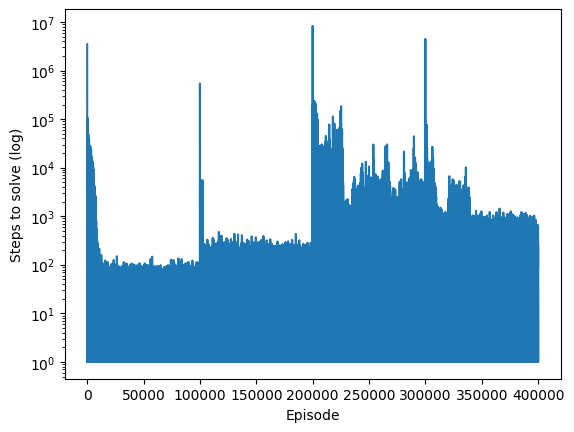

In [256]:
plt.plot(agent.ep_lengths)
plt.yscale("log")
plt.xlabel("Episode")
plt.ylabel("Steps to solve (log)")
plt.show()

In [257]:
episode = agent.play_episode()
print("Episode finished! Rendering animation...")
frames = []
for state in episode:
    track_state = racetrack.track.copy()
    track_state[state[0], state[1]] = 10
    fig, ax = plt.subplots()
    sns.heatmap(track_state, ax=ax)
    ax.axis('off')
    # Save the frame as an image
    plt.savefig('temp_frame.png', bbox_inches='tight', pad_inches=0)
    frames.append(imageio.v2.imread('temp_frame.png'))
    plt.close()

# Create a GIF from the collected frames
imageio.mimsave('episode_heatmap.gif', frames, fps=2, loop=0)

# Clean up temporary files if needed
os.remove('temp_frame.png')
Image(url='episode_heatmap.gif')

KeyboardInterrupt: 

## $Exercise\ \mathcal{5.15}$

#### Make new equations analogous to the importance-sampling Monte Carlo estimates (5.5) and (5.6) , but for action value estimates $Q(s,a)$. You will need new notation $\mathcal{T}(s,a)$ for the time steps on which the state–action pair $s,a$ is visited on the episode. Do these estimates involve more or less importance-sampling correction?

As the first step of the return is not sampled according to a policy, the importance sampling ratio is not influenced by it. There is therefore one step less than for state values.
$$
\begin{align}
Q(s,a)&\doteq\frac{\sum_{t\in\mathcal{T}(s)}\rho_{t+1:T(s)-1}G_t}{|\mathcal{T}(s)|} \\
Q(s,a)&\doteq\frac{\sum_{t\in\mathcal{T}(s)}\rho_{t+1:T(s)-1}G_t}{\sum_{t\in\mathcal{T}(s)}\rho_{t+1:T(s)-1}}
\end{align}
$$